In [ ]:
!pip install qujax

In [ ]:
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

In [ ]:
def expected_kernel(kernel, data1, weights1, data2, weights2):
    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()


def mmd(kernel, data1, weights1, data2, weights2):
    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params


def gaussian_kernel(s1, s2):
    return jnp.exp(-jnp.square(s1 - s2) / bandwidth_sq)


def param_to_mmd(param):
    data_probs = jnp.ones(len(data)) / len(data)
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, data, data_probs)

def param_to_mmd_stochastic(param, batch_size = 200):
    data_probs = jnp.ones(batch_size) / batch_size
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, np.random.choice(data, batch_size), data_probs)

def compute_av_probs(params, burn_in):
    probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(params[burn_in:])
    return probs.mean(axis=0)

In [ ]:
def run_simulation(init_param,n_params, Nsteps, beta, train_keys, noise_multiplicative_factor, stepsize = 0.1):
    import time

    bar_length = 30

    params = jnp.zeros((Nsteps, n_params))
    params = params.at[0].set(init_param)

    cost_vals = jnp.zeros(Nsteps - 1)

    start_time = time.time() # Record the start time

    for step in range(1, Nsteps):
        cost_val, cost_grad = param_to_mmd_and_grad(params[step - 1])
          # Add noise to the cost_grad
        noise = noise_multiplicative_factor * random.normal(train_keys[step - 1], shape=cost_grad.shape, dtype=jnp.float32)
        cost_grad = cost_grad + noise

        cost_vals = cost_vals.at[step - 1].set(cost_val)

        new_param = (
            params[step - 1]
            - stepsize * cost_grad
            + jnp.sqrt(2 * stepsize / beta)
            * random.normal(train_keys[step - 1], shape=(n_params,))
        )
        params = params.at[step].set(new_param)

        progress = step / Nsteps
        filled_length = int(bar_length * progress)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)
        elapsed_time = time.time() - start_time # Compute the elapsed time
        remaining_time = (elapsed_time / step) * (Nsteps - step) # Estimate the remaining time
        print(f'\rProgress: |{bar}| {progress:.2%} | Iteration: {step}/{Nsteps} | Cost: {cost_val:.6f} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {remaining_time:.2f}s', end='')

    print() # Move to the next line after the progress bar

    total_run_time = time.time() - start_time # Compute the total run time

    return params, cost_vals, total_run_time

Progress: |█████████████████████████████-| 99.98% | Iteration: 4999/5000 | Cost: 0.352926 | Elapsed Time: 28.19s | Estimated Remaining Time: 0.01s
Progress: |█████████████████████████████-| 99.98% | Iteration: 4999/5000 | Cost: 0.082127 | Elapsed Time: 29.40s | Estimated Remaining Time: 0.01s
Progress: |█████████████████████████████-| 99.98% | Iteration: 4999/5000 | Cost: 0.011721 | Elapsed Time: 28.11s | Estimated Remaining Time: 0.01s
Progress: |█████████████████████████████-| 99.98% | Iteration: 4999/5000 | Cost: 0.000990 | Elapsed Time: 28.85s | Estimated Remaining Time: 0.01s


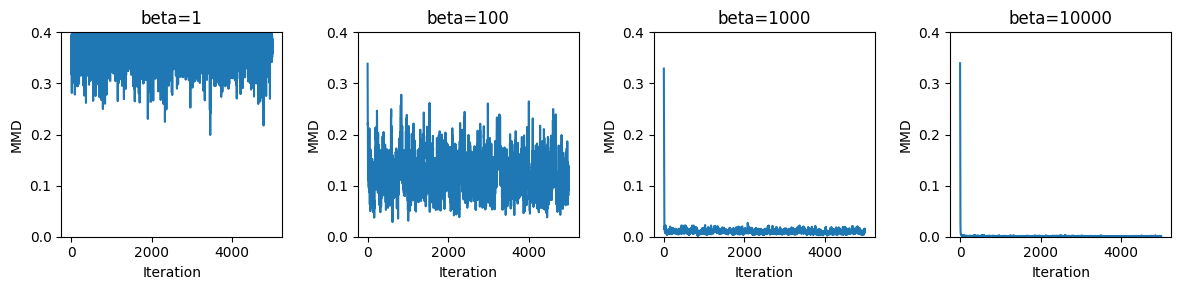

In [ ]:
### test for betas
with open(f'gen_data.pkl', 'rb') as file:
    data = pickle.load(file)

betas = [1, 100, 1000, 10000]  # Set the range of betas for the sim
noise_multiplicative_factors = [0.0]

number_of_data_points = 5000
n_steps = 5000
n_qubits = 8
circuit_depth = 3
init_rad = 0.001 / jnp.pi
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)

## These take awhile for large data sets
# computes pairwise
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)

# get bandwidth
bandwidth_sq = 5.7478714 #jnp.median(dist_mat) / 2
results_beta_stochastic = {}

fig1, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

for i, noise_multiplicative_factor in enumerate(noise_multiplicative_factors):
  for j, beta in enumerate(betas):
      gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
      param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
      param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd_stochastic))

      init_param = random.uniform(
          init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
      )

      train_keys = random.split(train_key, n_steps - 1)
      params, cost_vals, total_run_time = run_simulation(init_param, n_params, n_steps, beta, train_keys, noise_multiplicative_factor)

      ax1[j].plot(cost_vals)
      ax1[j].set_title(f'beta={beta}')#, sigma={noise_multiplicative_factor}')
      ax1[j].set_xlabel("Iteration")
      ax1[j].set_ylabel("MMD")
      ax1[j].set_ylim(0, 0.4)

      final_params = params[-1]
      final_st = param_to_st(final_params)

      results_beta_stochastic[(i, j)] = (jnp.square(jnp.abs(final_st.flatten())), cost_vals, total_run_time, params, beta, noise_multiplicative_factor)

plt.tight_layout()
plt.show()

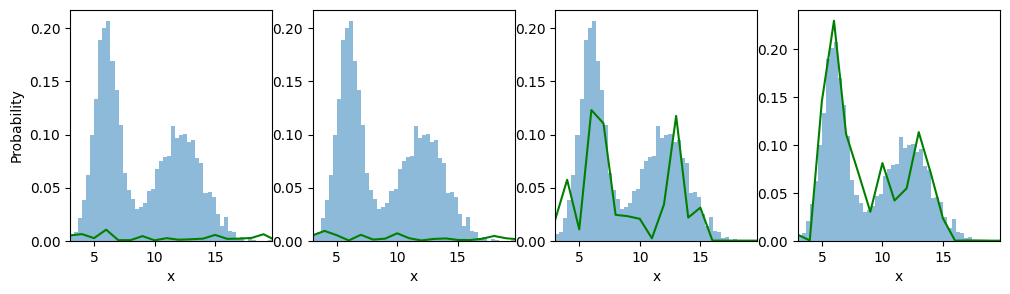

In [ ]:
# Iterate over the results_beta dictionary and plot each set of results
burn_in = 1000
min_data, max_data = data.min(), data.max()
fig2, ax2 = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
for (i,j), (final_st, cost,_, params, beta, noise_multiplicative_factor) in results_beta_stochastic.items():
    ax2[j].hist(data, bins=50, density=True, alpha=0.5)
    #av_probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(params[burn_in:]).mean(0)
    av_probs = jnp.square(jnp.abs(param_to_st(np.array(params[burn_in:]).mean(0)).flatten()))
    ax2[j].plot(av_probs, label="Averaged over parameters", color='green')
    ax2[j].set_xlim(min_data, max_data)
    if j == 0:
      ax2[j].set_ylabel("Probability")
    ax2[j].set_xlabel("x")
    #ax2[j].legend(fontsize='small')
plt.show()

In [ ]:
# Save results_beta to a file
with open(f'results_beta_sgld.pkl', 'wb') as file:
    pickle.dump(results_beta_sgld, file)

In [ ]:
with open(f'gen_data.pkl', 'rb') as file:
    data = pickle.load(file)

betas = [1, 100, 1000]
results_beta = {}

for beta in betas:

  number_of_data_points = 5000
  n_steps = 5000
  burn_in = 1000
  n_qubits = 8
  circuit_depth = 3
  random_key = random.PRNGKey(0)
  init_key, train_key = random.split(random_key)
  bandwidth_sq = 5.7478714
  noise_multiplicative_factor = 10.

  gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
  param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
  param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))

  init_param = random.uniform(
      init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
  )

  train_keys = random.split(train_key, n_steps - 1)
  params, cost_vals, total_run_time = run_simulation(init_param, n_params, n_steps, beta, train_keys, noise_multiplicative_factor)

  results_beta[beta] = (jnp.square(jnp.abs(final_st.flatten())), cost_vals, total_run_time, params, beta, noise_multiplicative_factor)


NameError: name 'run_simulation' is not defined

(3.0167486667633057, 19.71265411376953)

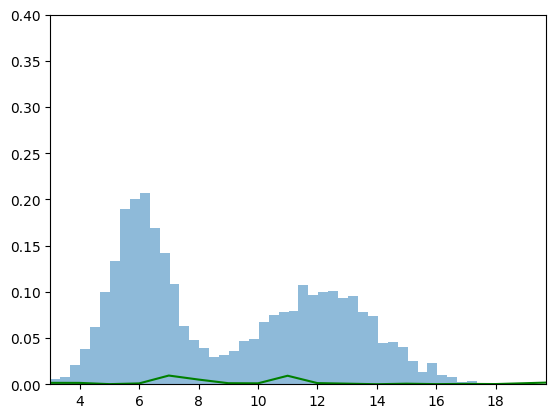

In [ ]:
av_probs = jnp.square(jnp.abs(param_to_st(np.array(params[burn_in:]).mean(0)).flatten()))
plt.hist(data, bins=50, density=True, alpha=0.5)
plt.plot(av_probs, label="Averaged over parameters", color='green')
plt.ylim(0, 0.4)
plt.xlim(data.min(), data.max())